In [1]:
import warnings
warnings.simplefilter('ignore')

import gc
import re
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm.auto import tqdm

## Get Session Info

In [2]:
df_sess = pd.read_csv('sessions_train.csv')
df_sess = df_sess[df_sess['locale']=='UK'][:5000]

In [4]:
def str2list(x):
    x = x.replace('[', '').replace(']', '').replace("'", '').replace('\n', ' ').replace('\r', ' ')
    l = [i for i in x.split() if i]
    return l

In [5]:
next_item_dict = defaultdict(list)

for _, row in tqdm(df_sess.iterrows(), total=len(df_sess)):
    prev_items = str2list(row['prev_items'])
    next_item = row['next_item']
    prev_items_length = len(prev_items)
    if prev_items_length <= 1:
        next_item_dict[prev_items[0]].append(next_item)
    else:
        for i, item in enumerate(prev_items[:-1]):
            next_item_dict[item].append(prev_items[i+1])
        next_item_dict[prev_items[-1]].append(next_item)

100%|████████████████████████████████████| 5000/5000 [00:00<00:00, 20785.18it/s]


In [6]:
# next_item_dict

In [9]:
k = []
v = []

for item in next_item_dict:
    k.append(item)
    v.append(next_item_dict[item])
    
df_next = pd.DataFrame({'item': k, 'next_item': v})
df_next = df_next.explode('next_item').reset_index(drop=True)
df_next

,item,next_item
0,B0BFDL54Y7,B0BFDR9X13
1,B0BFDR9X13,B07J4WF8VH
2,B07J4WF8VH,B07Y21LDJX
3,B07Y21LDJX,B07Y227WNJ
4,B07FM2GLNQ,B07GZW3P4W
...,...,...
35770,B0813XRBQG,B000J69D12
35771,B08MW1FYMT,B07XV9Q6VR
35772,B07XV9Q6VR,B0B47JKF4V
35773,B0B47JKF4V,B09GSHBNBL


In [10]:
df_next.head()

,item,next_item
0,B0BFDL54Y7,B0BFDR9X13
1,B0BFDR9X13,B07J4WF8VH
2,B07J4WF8VH,B07Y21LDJX
3,B07Y21LDJX,B07Y227WNJ
4,B07FM2GLNQ,B07GZW3P4W


In [12]:
dt = df_next[['item', 'next_item']].value_counts().to_frame().rename(columns={0: 'weight'}).reset_index()

In [14]:
dt.head()

,item,next_item,weight
0,B08PKLFM9T,B08F2NDB39,14
1,B077L4Y11C,B076VDGMNR,10
2,B08KFHDPY9,B0851KN668,10
3,B07KWYGTC6,B07KX2N355,10
4,B076VDGMNR,B07H796FNF,9


## Combine Session Info and Product Info

In [17]:
products_final = pd.read_csv('products_final2.csv', index_col='id')

In [18]:
combined_embeddings = np.column_stack([products_final[i].values for i in products_final.columns])
df = pd.DataFrame()
df['item'] = products_final.index
df['combined_embedding_pca'] = list(combined_embeddings)
df

,item,combined_embedding_pca
0,B087LZNPHS,"[4.039271368332172, -0.6527305027124629, 2.721..."
1,B08THFN1KX,"[0.9689579416102252, -2.264874936071531, 3.204..."
2,0804185328,"[-2.8264712242074497, 1.0217084708044923, -5.7..."
3,B09VBKDBW6,"[-3.880455527603429, -0.0799160960453152, -1.3..."
4,B096ZW8B49,"[-4.762424174184446, -3.123900524163788, 1.614..."
...,...,...
500175,B08D7KW8VK,"[6.313017193849209, 1.4582114182372052, 5.1177..."
500176,B073WXLXR9,"[3.381486509047898, -0.5125668660527173, -2.40..."
500177,1529393833,"[2.4607237564285893, 0.2659599673310411, -2.24..."
500178,B0B3TJ1NDN,"[-8.525614774131284, -7.50096378271608, 1.4920..."


In [19]:
da = dt.merge(df, how = 'left', on='item')
da = da.merge(df, how = 'left', left_on='next_item', right_on='item')

In [20]:
da = da[['item_x', 'next_item', 'weight', 'combined_embedding_pca_x', 'combined_embedding_pca_y']]
da = da.rename(columns={'item_x':'source', 'next_item':'target', 'combined_embedding_pca_x':'combined_embedding_pca_source', 'combined_embedding_pca_y':'combined_embedding_pca_target'})

In [21]:
da.isna().sum()/len(da)

source                           0.0
target                           0.0
weight                           0.0
combined_embedding_pca_source    0.0
combined_embedding_pca_target    0.0
dtype: float64

In [22]:
da.head()

,source,target,weight,combined_embedding_pca_source,combined_embedding_pca_target
0,B08PKLFM9T,B08F2NDB39,14,"[-8.404405953458218, -9.375031826382688, -1.53...","[-8.539231755832454, -9.303483563610223, -1.36..."
1,B077L4Y11C,B076VDGMNR,10,"[1.2220793232764304, 2.022893734154159, 11.554...","[1.067575509942718, 1.4748413211489186, 12.157..."
2,B08KFHDPY9,B0851KN668,10,"[5.768026466881847, 2.9701240711536983, 8.2145...","[4.441227159820258, 5.342169353738097, 5.31457..."
3,B07KWYGTC6,B07KX2N355,10,"[-10.07698234433678, -2.5829571901547728, -2.0...","[-6.021827986651372, -3.761950348247283, -3.47..."
4,B076VDGMNR,B07H796FNF,9,"[1.067575509942718, 1.4748413211489186, 12.157...","[1.272921255112478, 2.2114844362950645, 11.867..."


In [23]:
db = pd.DataFrame()
db['item'] = list(set(da['source'].to_list()+da['target'].to_list()))
db = db.merge(df, how='left', on='item')
db

,item,combined_embedding_pca
0,B01CAQ3UPI,"[-1.590069684870833, 9.47367457259633, -1.7357..."
1,B07RYSDKRM,"[-4.5083483805961935, 6.607109223883622, -6.87..."
2,B01EX14RNC,"[1.7124724534825904, 3.806230809901896, -2.635..."
3,B09NBNG4B6,"[3.812497622234386, 4.030011702622757, -1.3283..."
4,B084KGV2VJ,"[-2.452600699259748, 10.261248103760988, 0.583..."
...,...,...
31084,B07FN4F7SM,"[-8.398024445926852, 0.5647310709487044, -3.28..."
31085,B09NW2D47K,"[-4.169525227042755, 1.810566896092152, 2.4069..."
31086,B06XPF6ZSH,"[-6.169803304636673, -4.550688530771722, 0.333..."
31087,B007CVCULW,"[-7.293093195928278, -4.668198551604805, -4.19..."


## GNN

In [25]:
combined_embeddings_pca_source = np.array([da['combined_embedding_pca_source'][i] for i in range(len(da))])
combined_embeddings_pca_target = np.array([da['combined_embedding_pca_target'][i] for i in range(len(da))])

In [26]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [27]:

import torch
from torch_geometric.data import Data

# Create node features tensor
x = torch.tensor(combined_embeddings_pca_source, dtype=torch.float)
y = torch.tensor(combined_embeddings_pca_target, dtype=torch.float)


# Create dictionary mapping node labels to node indices
node_indices = {node_label: i for i, node_label in enumerate(set(da['source']).union(set(da['target'])))}


# Create matrix of edge indices
edge_indices = torch.tensor([(node_indices[source], node_indices[target]) for source, target in zip(da['source'], da['target'])], dtype=torch.long).t()

# Create tensor of edge weights
edge_weights = torch.tensor(da['weight'].values, dtype=torch.float)

# Create PyTorch Geometric Data object with edge weights
data = Data(x=x, edge_index=edge_indices, edge_attr=edge_weights)

data.y = y


In [28]:
data

Data(x=[32655, 252], edge_index=[2, 32655], edge_attr=[32655], y=[32655, 252])

### Link Prediction

In [45]:
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(
            dim=-1
        )  # product of a pair of nodes on each edge

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()
    

def train_link_predictor(
    model, train_data, val_data, optimizer, criterion, n_epochs=100
):
    losses, aucs = [], []
    for epoch in range(1, n_epochs + 1):

        model.train()
        optimizer.zero_grad()
        z = model.encode(train_data.x, train_data.edge_index)

        # sampling training negatives for every training epoch
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        val_auc = eval_link_predictor(model, val_data)
        aucs.append(val_auc)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

    return model, losses, aucs


@torch.no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [46]:
 import torch_geometric.transforms as T
 
 split = T.RandomLinkSplit(
     num_val=0.05,
     num_test=0.1,
     is_undirected=True,
     add_negative_train_samples=False,
     neg_sampling_ratio=1.0,
 )
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
train_data, val_data, test_data = split(data)
train_data, val_data, test_data = train_data.to(device), val_data.to(device), test_data.to(device)

In [48]:
from torch_geometric.nn import GCNConv
model = Net(data.num_features, 256, data.num_features).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2)
criterion = torch.nn.BCEWithLogitsLoss()
model, losses, aucs = train_link_predictor(model, train_data, val_data, optimizer, criterion, 200)

test_auc = eval_link_predictor(model, test_data)
print(f"Test: {test_auc:.3f}")

Epoch: 010, Train Loss: 2.686, Val AUC: 0.568
Epoch: 020, Train Loss: 1.458, Val AUC: 0.576
Epoch: 030, Train Loss: 0.797, Val AUC: 0.584
Epoch: 040, Train Loss: 0.566, Val AUC: 0.576
Epoch: 050, Train Loss: 0.507, Val AUC: 0.562
Epoch: 060, Train Loss: 0.486, Val AUC: 0.562
Epoch: 070, Train Loss: 0.459, Val AUC: 0.566
Epoch: 080, Train Loss: 0.448, Val AUC: 0.568
Epoch: 090, Train Loss: 0.447, Val AUC: 0.570
Epoch: 100, Train Loss: 0.428, Val AUC: 0.576
Epoch: 110, Train Loss: 0.423, Val AUC: 0.588
Epoch: 120, Train Loss: 0.426, Val AUC: 0.590
Epoch: 130, Train Loss: 0.416, Val AUC: 0.592
Epoch: 140, Train Loss: 0.416, Val AUC: 0.587
Epoch: 150, Train Loss: 0.413, Val AUC: 0.587
Epoch: 160, Train Loss: 0.410, Val AUC: 0.586
Epoch: 170, Train Loss: 0.411, Val AUC: 0.579
Epoch: 180, Train Loss: 0.409, Val AUC: 0.578
Epoch: 190, Train Loss: 0.405, Val AUC: 0.574
Epoch: 200, Train Loss: 0.405, Val AUC: 0.568
Test: 0.555


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


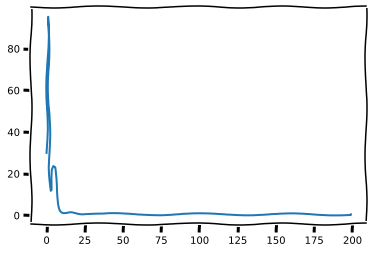

In [49]:
import matplotlib.pyplot as plt
with plt.xkcd():
    plt.plot(losses)

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


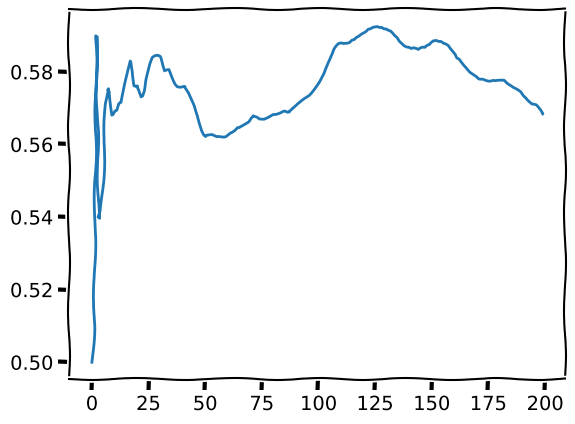

In [50]:
import matplotlib.pyplot as plt
with plt.xkcd():
    plt.plot(aucs)

## GNN-REG

In [143]:
num_nodes = data.num_nodes
indices = torch.arange(num_nodes)
shuffled_indices = torch.randperm(num_nodes)

train_indices = shuffled_indices[:int(num_nodes * 0.6)]
val_indices = shuffled_indices[int(num_nodes * 0.6):int(num_nodes * 0.8)]
test_indices = shuffled_indices[int(num_nodes * 0.8):]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = 1

val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[val_indices] = 1

test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[test_indices] = 1

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [144]:
data

Data(x=[32655, 448], edge_index=[2, 32655], edge_attr=[32655], y=[32655, 448], train_mask=[32655], val_mask=[32655], test_mask=[32655])

In [145]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

# Define the GCN model for regression
class GCNRegression(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNRegression, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [146]:
# Define the training loop
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [147]:
# Load the data and model, and train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = GCNRegression(data.num_node_features, 256, data.num_node_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
losses=[]
for epoch in range(1, 201):
    loss = train(model, optimizer, data)
    losses.append(loss)
    if epoch%10==0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

Epoch 10, Loss: 2.0116
Epoch 20, Loss: 1.9415
Epoch 30, Loss: 1.8751
Epoch 40, Loss: 1.8379
Epoch 50, Loss: 1.8141
Epoch 60, Loss: 1.7975
Epoch 70, Loss: 1.7855
Epoch 80, Loss: 1.7764
Epoch 90, Loss: 1.7693
Epoch 100, Loss: 1.7637
Epoch 110, Loss: 1.7592
Epoch 120, Loss: 1.7555
Epoch 130, Loss: 1.7525
Epoch 140, Loss: 1.7500
Epoch 150, Loss: 1.7478
Epoch 160, Loss: 1.7460
Epoch 170, Loss: 1.7446
Epoch 180, Loss: 1.7430
Epoch 190, Loss: 1.7416
Epoch 200, Loss: 1.7403


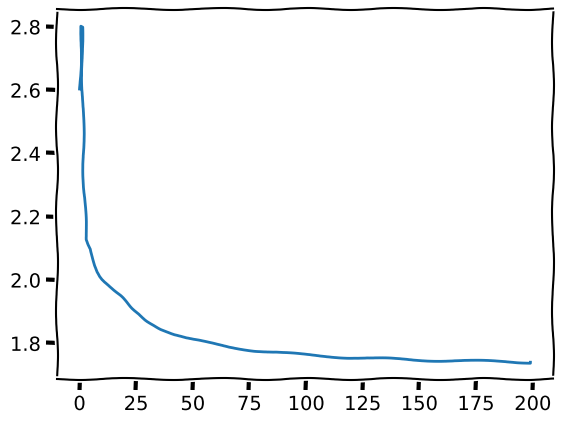

In [148]:
import matplotlib.pyplot as plt
with plt.xkcd():
    plt.plot(losses)

In [149]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    test_loss = F.mse_loss(out[data.test_mask], data.y[data.test_mask])
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 1.8921
